In [1]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%bash
fusermount -uz /mnt/work/dhuseljic
sshfs cluster.ies:/mnt/work/dhuseljic/ /mnt/work/dhuseljic

In [3]:

def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    exp_checkpoint = path / 'model_final.pth'

    if exp_cfg.is_file():
        cfg =  OmegaConf.load(exp_cfg)
        results['cfg'] = cfg
    else:
        raise ValueError(f'Config missing for {exp_cfg}')

    if exp_json.is_file():
        data = load_json(exp_json)
        results['results'] = data
    else:
        raise ValueError(f'Results missing for {exp_json}')

    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    for exp_path in result_path.glob(glob_pattern):
        print('> Found', exp_path.name)
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'/mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{18}/'
exp_results = get_experiments(Path(path), 'seed1')
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18/seed1
dict_keys(['test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['accuracy', 'nll', 'brier', 'tce', 'ace'])


## Aleatoric Results

In [4]:
root_path = Path('/mnt/work/dhuseljic/results/udal/active_learning/')
dataset = 'CIFAR10'
model = 'resnet18'
experiments = {}
num_cycles = 38
# Deterministic
experiments.update({
    'random eval': root_path / f'{dataset}/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'lc eval': root_path / f'{dataset}/resnet18/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'margin eval': root_path / f'{dataset}/resnet18/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'entropy eval': root_path / f'{dataset}/resnet18/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
})

# # Labels smoothing
experiments.update({
    'random (ls)': root_path / f'{dataset}/resnet18_labelsmoothing/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'lc (ls)': root_path / f'{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'margin (ls)': root_path / f'{dataset}/resnet18_labelsmoothing/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'entropy (ls)': root_path / f'{dataset}/resnet18_labelsmoothing/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'random (ls) eval': f'results/evaluation/{dataset}/resnet18_labelsmoothing/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    # 'least conf (ls) eval ': f'results/evaluation/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    # 'margin (ls) eval': f'results/evaluation/{dataset}/resnet18_labelsmoothing/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
    # 'entropy (ls) eval': f'results/evaluation/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
})
# 
# Mixup
experiments.update({
    'random (mixup)': root_path / f'{dataset}/resnet18_mixup/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'lc (mixup)': root_path / f'{dataset}/resnet18_mixup/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'margin (mixup)': root_path / f'{dataset}/resnet18_mixup/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'entropy (mixup)': root_path / f'{dataset}/resnet18_mixup/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
#     'random (mixup) eval': f'results/evaluation/{dataset}/resnet18_mixup/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
#     'least (mixup) conf eval': f'results/evaluation/{dataset}/resnet18_mixup/least_confident/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
#     'margin (mixup) eval': f'results/evaluation/{dataset}/resnet18_mixup/margin/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
#     'entropy (mixup) eval': f'results/evaluation/{dataset}/resnet18_mixup/entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{num_cycles}/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/12 [00:00<?, ?it/s]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed9
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed4
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_

  8%|▊         | 1/12 [00:04<00:46,  4.21s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed4
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed9
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/least_confident/N_INIT128__ACQ_

 17%|█▋        | 2/12 [00:08<00:40,  4.09s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed8
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_l

 25%|██▌       | 3/12 [00:12<00:36,  4.05s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed9
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed4
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal

 33%|███▎      | 4/12 [00:16<00:33,  4.22s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed4
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed9
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR1

 42%|████▏     | 5/12 [00:54<01:53, 16.22s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed8
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10

 50%|█████     | 6/12 [01:55<03:09, 31.51s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed9
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed4
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR

 58%|█████▊    | 7/12 [03:22<04:08, 49.62s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed8
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learnin

 67%|██████▋   | 8/12 [04:47<04:04, 61.08s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed9
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed3
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed4
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2


 75%|███████▌  | 9/12 [04:55<02:12, 44.21s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed8
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR

 83%|████████▎ | 10/12 [04:58<01:03, 31.77s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed10
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed8
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7


 92%|█████████▏| 11/12 [05:03<00:23, 23.41s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed6
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed1
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed5
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed8
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed2
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38/seed7
> Found /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38

100%|██████████| 12/12 [05:13<00:00, 26.16s/it]


100%|██████████| 12/12 [00:00<00:00, 99.74it/s]


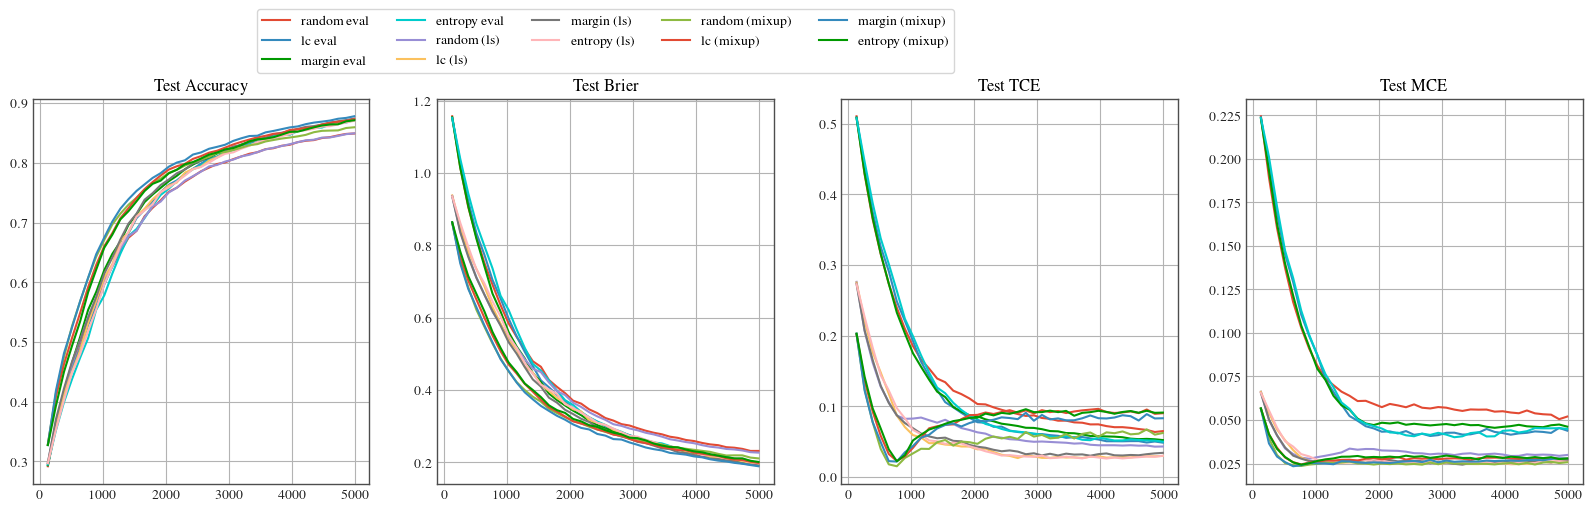

In [5]:
show_std = False
table_dict = {}
plt.figure(figsize=(20, 5))
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_mce = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        # train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        # train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_mce.append([data[cycle]['test_stats']['ace'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    # train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    # train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_mce_mean, test_mce_std = np.mean(test_mce, 0), np.std(test_mce, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'nll (Final)': test_nll_mean[-1], 
        'nll (AUC)': np.mean(test_nll_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1],
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_mce_mean[-1],
        'ACE (AUC)': np.mean(test_mce_mean), 
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test MCE')
    plt.plot(n_labeled_samples, test_mce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_mce_mean-test_mce_std, test_mce_mean+test_mce_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)
        

In [6]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict).T
print(df.to_latex(float_format="%.3f"))
print(df.to_markdown(tablefmt='github'))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & nll (Final) & nll (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & ACE (Final) & ACE (AUC) \\
\midrule
random eval & 0.849 & 0.720 & 0.528 & 1.070 & 0.231 & 0.425 & 0.065 & 0.138 & 0.052 & 0.074 \\
lc eval & 0.872 & 0.731 & 0.440 & 1.018 & 0.197 & 0.407 & 0.048 & 0.123 & 0.044 & 0.066 \\
margin eval & 0.873 & 0.738 & 0.441 & 0.998 & 0.196 & 0.398 & 0.052 & 0.124 & 0.046 & 0.068 \\
entropy eval & 0.872 & 0.726 & 0.441 & 1.038 & 0.197 & 0.415 & 0.050 & 0.126 & 0.045 & 0.067 \\
random (ls) & 0.850 & 0.721 & 0.537 & 0.926 & 0.227 & 0.395 & 0.043 & 0.073 & 0.030 & 0.032 \\
lc (ls) & 0.872 & 0.732 & 0.462 & 0.883 & 0.195 & 0.380 & 0.030 & 0.056 & 0.026 & 0.028 \\
margin (ls) & 0.874 & 0.739 & 0.455 & 0.864 & 0.191 & 0.370 & 0.034 & 0.059 & 0.027 & 0.028 \\
entropy (ls) & 0.871 & 0.729 & 0.463 & 0.889 & 0.197 & 0.384 & 0.030 & 0.058 & 0.026 & 0.029 \\
random (mixup) & 0.860 & 0.752 & 0.501 & 0.810 & 0.211 & 0.34

In [7]:
df1 = df[['nll (AUC)', 'brier (AUC)', 'TCE (AUC)', 'ACE (AUC)']]
print(df1.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & nll (AUC) & brier (AUC) & TCE (AUC) & ACE (AUC) \\
\midrule
random eval & 1.070 & 0.425 & 0.138 & 0.074 \\
lc eval & 1.018 & 0.407 & 0.123 & 0.066 \\
margin eval & 0.998 & 0.398 & 0.124 & 0.068 \\
entropy eval & 1.038 & 0.415 & 0.126 & 0.067 \\
random (ls) & 0.926 & 0.395 & 0.073 & 0.032 \\
lc (ls) & 0.883 & 0.380 & 0.056 & 0.028 \\
margin (ls) & 0.864 & 0.370 & 0.059 & 0.028 \\
entropy (ls) & 0.889 & 0.384 & 0.058 & 0.029 \\
random (mixup) & 0.810 & 0.349 & 0.058 & 0.026 \\
lc (mixup) & 0.808 & 0.351 & 0.085 & 0.029 \\
margin (mixup) & 0.784 & 0.338 & 0.078 & 0.027 \\
entropy (mixup) & 0.821 & 0.357 & 0.086 & 0.029 \\
\bottomrule
\end{tabular}



: 

## Epistemic Results

In [ ]:
dataset = 'SVHN'
experiments = {}

# MC-Dropout
experiments.update({
    'random (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'random eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio (MC-Dropout)': f'results/active_learning/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})
# Ensemble
experiments.update({
    'random (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'random eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'entropy eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'bald eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    'variation ratio eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})



all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/16 [00:00<?, ?it/s]

Searching in results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ

  6%|▋         | 1/16 [00:01<00:15,  1.02s/it]

Searching in results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4


 12%|█▎        | 2/16 [00:02<00:14,  1.03s/it]

> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
Searching in results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/

 19%|█▉        | 3/16 [00:03<00:14,  1.09s/it]

> Found results/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
Searching in results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_m

 25%|██▌       | 4/16 [00:04<00:14,  1.23s/it]

> Found results/evaluation/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
Searching in results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Fo

 31%|███▏      | 5/16 [00:05<00:12,  1.16s/it]

> Found results/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
Searching in results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mcdropout/bald/

 38%|███▊      | 6/16 [00:06<00:11,  1.15s/it]

Searching in results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found res

 44%|████▍     | 7/16 [00:07<00:10,  1.15s/it]

Searching in results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_mcdropout/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_mcdropout/varia

 50%|█████     | 8/16 [00:08<00:08,  1.11s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
>

 56%|█████▋    | 9/16 [00:10<00:07,  1.13s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_ensemble/r

 62%|██████▎   | 10/16 [00:11<00:06,  1.11s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found res

 69%|██████▉   | 11/16 [00:12<00:05,  1.15s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/evaluation/SVHN/resnet18_ensemble/bayesian_entropy/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/bayesi

 75%|███████▌  | 12/16 [00:13<00:04,  1.14s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/activ

 81%|████████▏ | 13/16 [00:14<00:03,  1.18s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/evaluation/SVHN/resnet18_ensemble/bald/N_INIT100__ACQ_S

 88%|████████▊ | 14/16 [00:16<00:02,  1.36s/it]

Searching in results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed6
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/active_learning/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/acti

 94%|█████████▍| 15/16 [00:17<00:01,  1.32s/it]

Searching in results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed9
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed3
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed4
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed0
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed7
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed5
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed2
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio/N_INIT100__ACQ_SIZE100__N_ACQ19/seed8
> Found results/evaluation/SVHN/resnet18_ensemble/variation_ratio

100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


100%|██████████| 16/16 [00:00<00:00, 62.10it/s]


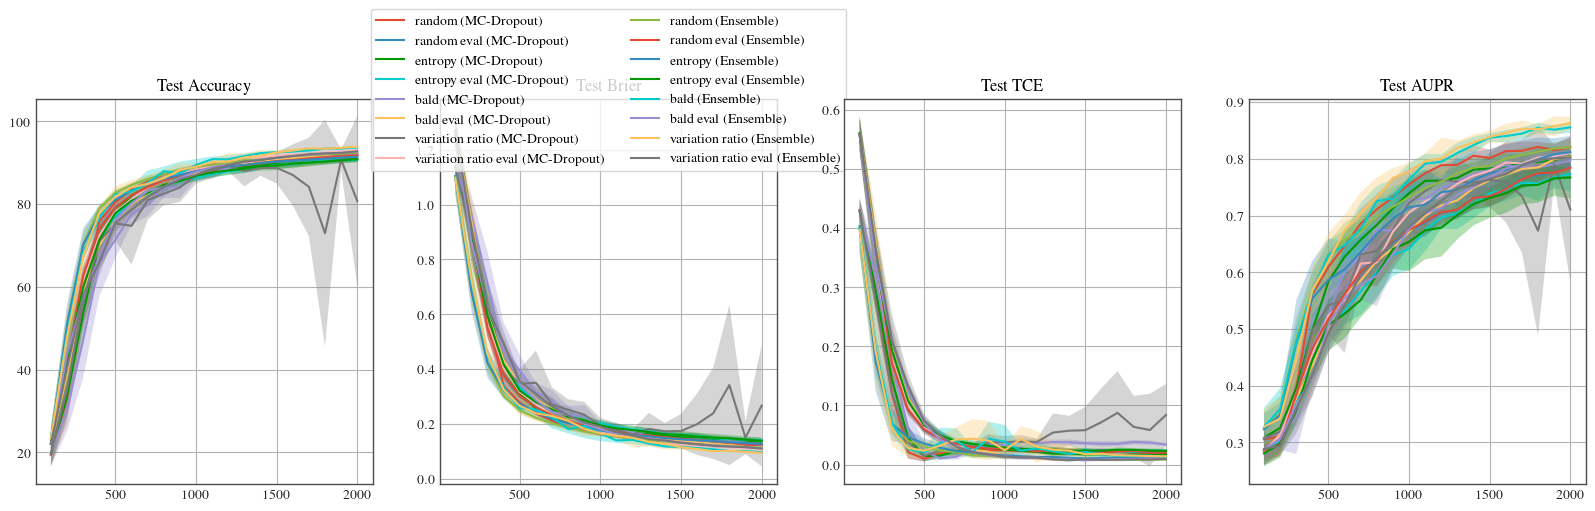

In [ ]:
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_aupr_cifar10= []
    test_aupr_cifar100 = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['test_brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['test_tce'] for cycle in data])
        test_aupr_cifar10.append([data[cycle]['test_stats']['test_CIFAR10_aupr'] for cycle in data])
        test_aupr_cifar100.append([data[cycle]['test_stats']['test_CIFAR100_aupr'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_aupr_cifar100_mean, test_aupr_cifar100_std = np.mean(test_aupr_cifar100, 0), np.std(test_aupr_cifar100, 0)
    test_aupr_cifar10_mean, test_aupr_cifar10_std = np.mean(test_aupr_cifar10, 0), np.std(test_aupr_cifar10, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1] / 100, 
        'acc (AUC)': np.mean(test_accs_mean) / 100, 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1], 
        'TCE (AUC)': np.mean(test_tce_mean), 
        'AUPR CIFAR10 (Final)': test_aupr_cifar10_mean[-1],
        'AUPR CIFAR10 (AUC)': np.mean(test_aupr_cifar10_mean),
        'AUPR CIFAR100 (Final)': test_aupr_cifar100_mean[-1],
        'AUPR CIFAR100 (AUC)': np.mean(test_aupr_cifar100_mean),
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test AUPR')
    plt.plot(n_labeled_samples, test_aupr_cifar100_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_aupr_cifar100_mean-test_aupr_cifar100_std, test_aupr_cifar100_mean+test_aupr_cifar100_std, alpha=.3)
    # plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [ ]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  acc (Final) &  acc (AUC) &  brier (Final) &  brier (AUC) &  TCE (Final) &  TCE (AUC) &  AUPR CIFAR10 (Final) &  AUPR CIFAR10 (AUC) &  AUPR CIFAR100 (Final) &  AUPR CIFAR100 (AUC) \\
\midrule
random (MC-Dropout)               &        0.920 &      0.804 &          0.120 &        0.279 &        0.019 &      0.060 &                 0.831 &               0.693 &                  0.821 &                0.688 \\
random eval (MC-Dropout)          &        0.919 &      0.806 &          0.125 &        0.295 &        0.021 &      0.082 &                 0.797 &               0.628 &                  0.786 &                0.624 \\
entropy (MC-Dropout)              &        0.908 &      0.790 &          0.137 &        0.299 &        0.017 &      0.061 &                 0.819 &               0.676 &                  0.805 &                0.668 \\
entropy eval (MC-Dropout)         &        0.908 &      0.791 &          0.140 &        0.316 &        0.023

/tmp/ipykernel_22410/3911846269.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.T.to_latex(float_format="%.3f"))


## Load Experiment

In [ ]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model

model_name = 'resnet18_mcdropout'
strat_name = 'random'
exp_path = Path(f'results/active_learning/CIFAR10/{model_name}/{strat_name}/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/seed1')
checkpoint = torch.load(exp_path / 'checkpoint.pth')
args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')

trainer = build_model(args, n_classes=10)
model = trainer.model
model.load_state_dict(checkpoint['model'])

args.dataset_path = '/datasets'
_, _, test_ds, _ = build_datasets(args)

2023-05-02 22:12:41.242831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:12:41.894472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
results = load_json(exp_path / 'results.json')
results['cycle19']['test_stats']

{'test_acc1': 72.94999694824219,
 'test_loss': 0.9619036912918091,
 'test_nll': 0.8499259948730469,
 'test_brier': 0.38014087080955505,
 'test_tce': 0.06486481428146362,
 'test_mce': 0.036187052726745605,
 'test_CIFAR100_auroc': 0.7402122050000001,
 'test_CIFAR100_aupr': 0.6967468314841072,
 'test_SVHN_auroc': 0.7186415776736323,
 'test_SVHN_aupr': 0.8092618874912202}

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

logits_list = []
targets_list = []
model.cuda()
model.eval()
for inputs, targets in test_loader:
    with torch.no_grad():
        logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

AttributeError: 'DropoutResNet18' object has no attribute 'forward_sample'

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)
probas = model.get_probas(test_loader, device='cuda').mean(1)
logits = probas.log()

In [ ]:
from dal_toolbox.metrics.calibration import ExpectedCalibrationError, TopLabelCalibrationError, AdaptiveCalibrationError
from torchmetrics.classification import Accuracy

acc_fn = Accuracy()
print('Accuracy: {}'.format(acc_fn(logits, targets)))
tce_fn = TopLabelCalibrationError(n_bins=15)
print('ECE: {}'.format(tce_fn(logits.softmax(-1), targets)))
ace_fn = AdaptiveCalibrationError()
print('ACE: {}'.format(ace_fn(logits.softmax(-1), targets)))
plt.figure(figsize=(5, 5))
plt.plot(tce_fn.results['confs'], tce_fn.results['accs'], '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.twinx()
plt.grid()
bar_x = [conf for conf in tce_fn.results['confs'] if not np.isnan(conf)]
bar_y = [n for n in tce_fn.results['n_samples'] if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
plt.savefig(f'plots_al/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()

ValueError: The `preds` and `target` should have the same first dimension.